In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# Single-frequency 2D

## Solving the heterogeneous PDE in 2D at different frequencies

In this experiment, I am investigating whether we can fit and perform elasticity reconstruction using 2D wave images for a single frequency. I have been able to this somewhat successfully for the 80 Hz image, but I now am testing whether we can use each different frequency in isolation.

Both the single-frequency 1D experiment and the 2D Helmholtz interactive training notebook seem to confirm that the Helmholtz PDE is simply worse than the heterogeneous PDE, so I am only evaluating the hetero PDE here.

The last experiment did not clearly elucidate which omega0 and activation function are best, so we evaluate the same ranges as before in this experiment.

There are 6 different frequencies ranging from 50-100 Hz by 10 Hz increments.

In [3]:
mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'fem_box')[0].frequency

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency       (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z               (z) float64 0.0 0.001 0.002 0.003 ... 0.007 0.008 0.009
  * component       (component) <U1 'z' 'y' 'x'
Data variables:
    u               (frequency, x, y, z, component) complex128 (7.43590828448...
    mu              (frequency, x,

<xarray.DataArray 'frequency' (frequency: 6)>
array([ 50.,  60.,  70.,  80.,  90., 100.])
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0

In [10]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx5000:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name fem_box \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --pde_name {pde_name} \\
    --omega0 {omega0} \\
    --n_layers {n_layers} \\
    --n_hidden {n_hidden} \\
    --activ_fn {activ_fn} \\
    --learning_rate {learning_rate} \\
    --pde_loss_wt {pde_loss_wt} \\
    --data_loss_wt {data_loss_wt} \\
    --batch_size {batch_size} \\
    --n_domain {n_domain} \\
    --n_iters {n_iters} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}    
'''
name = 'train_{frequency}_{xyz_slice}_{pde_name}_{omega0}_{n_hidden}_{activ_fn}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[50, 60, 70, 80, 90, 100],
    xyz_slice=['2D'],
    pde_name=['hetero'],
    omega0=[8, 16, 32],
    n_layers=[5],
    n_hidden=[128, 256, 512],
    activ_fn=['s', 't'],
    learning_rate=1e-4,
    pde_loss_wt=1e-8,
    data_loss_wt=1,
    batch_size=80,
    n_domain=128-80,
    pde_distrib='uniform',
    n_iters=100000,
    test_every=1000,
    save_every=10000
)

len(param_space)

108

In [11]:
%autoreload
expt_name = '2022-07-25_2D_fixed'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

#import pandas as pd
#jobs = pd.read_csv(f'{expt_name}.jobs')

100%|██████████| 108/108 [00:06<00:00, 17.26it/s]
[9976004, 9976005, 9976006, 9976007, 9976008, 9976009, 9976010, 9976011, 9976012, 9976013, 9976014, 9976015, 9976016, 9976017, 9976018, 9976019, 9976020, 9976021, 9976022, 9976023, 9976024, 9976025, 9976026, 9976027, 9976028, 9976029, 9976030, 9976031, 9976032, 9976033, 9976034, 9976035, 9976036, 9976037, 9976038, 9976039, 9976040, 9976041, 9976042, 9976043, 9976044, 9976045, 9976046, 9976047, 9976048, 9976049, 9976050, 9976051, 9976052, 9976053, 9976054, 9976055, 9976056, 9976057, 9976058, 9976059, 9976060, 9976061, 9976062, 9976063, 9976064, 9976065, 9976066, 9976067, 9976068, 9976069, 9976070, 9976071, 9976072, 9976073, 9976074, 9976075, 9976076, 9976077, 9976078, 9976079, 9976080, 9976081, 9976082, 9976083, 9976084, 9976085, 9976086, 9976087, 9976088, 9976089, 9976090, 9976091, 9976092, 9976093, 9976094, 9976095, 9976096, 9976097, 9976098, 9976099, 9976100, 9976101, 9976102, 9976103, 9976104, 9976105, 9976106, 9976107, 9976108, 9976

In [24]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
9976004,train_50_2D_hetero_8_128_s,NaN,NaN,NaN,None,None
9976005,train_50_2D_hetero_8_128_t,NaN,NaN,NaN,None,None
9976006,train_50_2D_hetero_8_256_s,NaN,NaN,NaN,None,None
9976007,train_50_2D_hetero_8_256_t,NaN,NaN,NaN,None,None
9976008,train_50_2D_hetero_8_512_s,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...
9976107,train_100_2D_hetero_32_128_t,NaN,NaN,NaN,None,None
9976108,train_100_2D_hetero_32_256_s,NaN,NaN,NaN,None,None
9976109,train_100_2D_hetero_32_256_t,NaN,NaN,NaN,None,None


In [49]:
metrics = ps.metrics(jobs)

# did all models train to 100k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

param_cols = ['frequency', 'omega0', 'n_hidden', 'activ_fn'] # experimental parameters
index_cols = ['iteration', 'variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'mean_abs_value'] # metric values

metrics = metrics.groupby(['job_name'] + param_cols + index_cols, sort=False)[metric_cols].mean().unstack(level=[6])

def metric_map(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'mean_abs_value': 'MAV',
        'power_density': 'SPD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]

m = metrics.reset_index()
metrics

u_pred_MSAV  \
job_name                     frequency omega0 n_hidden activ_fn iteration spatial_frequency_bin spatial_region                 
train_50_2D_hetero_8_128_s   50        8      128      s        0         all                   all             2.010830e-10   
                                                                                                0                        NaN   
                                                                                                1                        NaN   
                                                                                                2                        NaN   
                                                                                                3                        NaN   
...                                                                                                                      ...   
train_100_2D_hetero_32_512_t 100       32     512      t        100000    6.0                   all                      NaN   
                                                                          7.0                   all                      NaN   
                                                                          8.0                   all                      NaN   
                                                                          9.0                   all                      NaN   
                                                                          10.0                  all                      NaN   

                                                                                                                 u_pred_MSAE  \
job_name                     frequency omega0 n_hidden activ_fn iteration spatial_frequency_bin spatial_region                 
train_50_2D_hetero_8_128_s   50        8      128      s        0         all                   all             3.517274e-10   
                                                                                                0                        NaN   
                                                                                                1                        NaN   
                                                                                                2                        NaN   
                                                                                                3                        NaN   
...                                                                                                                      ...   
train_100_2D_hetero_32_512_t 100       32     512      t        100000    6.0                   all                      NaN   
                                                                          7.0                   all                      NaN   
                                                                          8.0                   all                      NaN   
                                                                          9.0                   all                      NaN   
                                                                          10.0                  all                      NaN   

                                                                                                                 u_true_MSAV  \
job_name                     frequency omega0 n_hidden activ_fn iteration spatial_frequency_bin spatial_region                 
train_50_2D_hetero_8_128_s   50        8      128      s        0         all                   all             1.544610e-10   
                                                                                                0                        NaN   
                                                                                                1                        NaN   
                                                                                                2                        NaN   
               

<IPython.core.display.Javascript object>


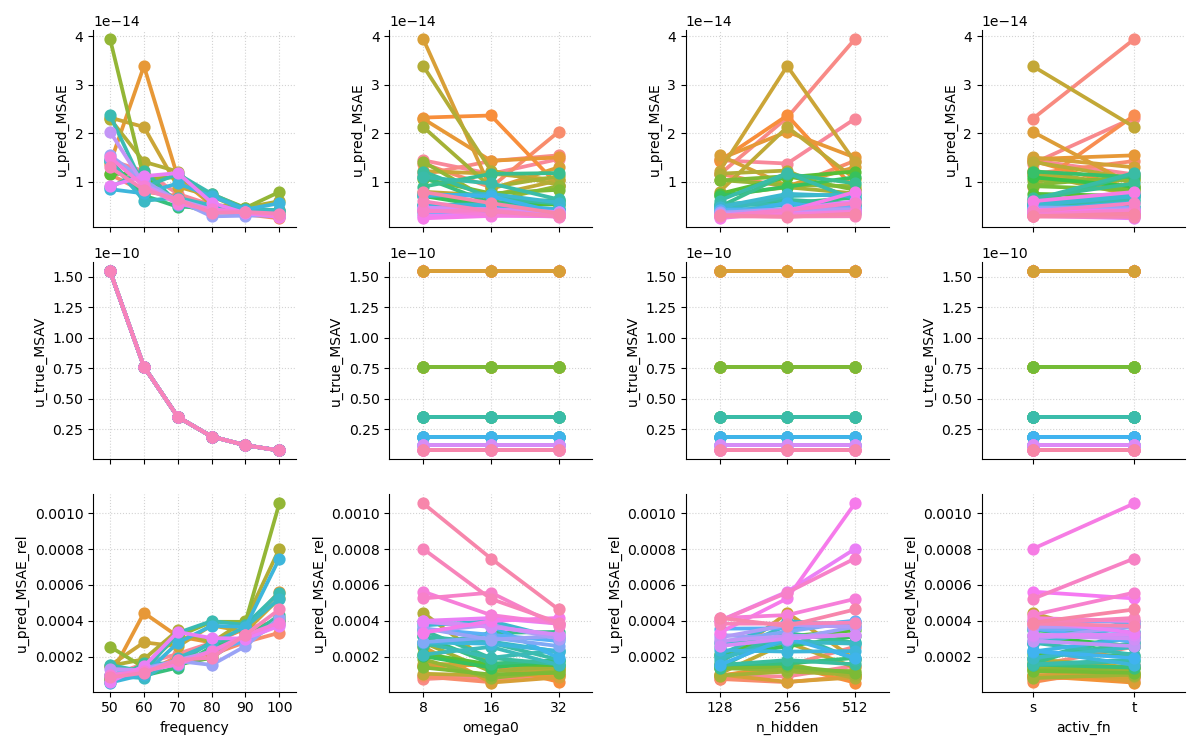

In [50]:
m['u_pred_MSAE_rel'] = m['u_pred_MSAE'] / m['u_true_MSAV']

fig = ps.plot(
    m[m.iteration == 100e3].copy(),
    x=param_cols,
    y=['u_pred_MSAE', 'u_true_MSAV', 'u_pred_MSAE_rel'],
    height=2.5,
    width=3,
    legend=False,
    tight=True
)

There is a clear trend of lower wave field error at higher frequencies, but this mostly due to the higher frequency wave images having lower amplitude. We can correct for this by plotting the relative wave field error. In the relative error plot, we see the inverse trend: higher frequency wave images have higher relative error in the predicted wave field. This is probably related to the spectral bias of neural networks- it's easier for them to learn lower frequencies than higher ones.

There also is a slight trend with respect to the omega0 parameter. Omega0 of 16 appears slightly better than 8, and in some cases increasing to 32 improves performance over 16.

It is not at all clear if there is a trend with model width.

<IPython.core.display.Javascript object>


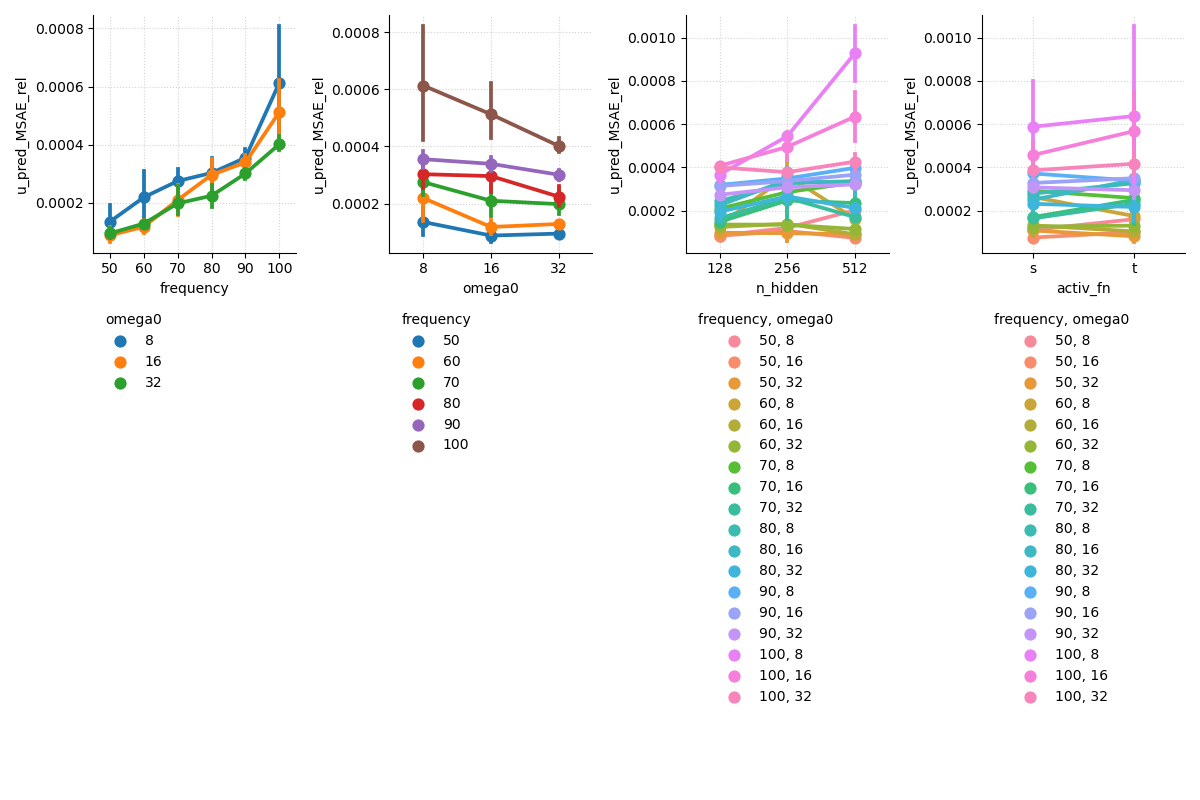

In [51]:
fig = ps.plot(
    m[m.iteration == 100e3].copy(),
    x=param_cols,
    y=['u_pred_MSAE_rel'],
    hue=('frequency', 'omega0'),
    height=8,
    width=3,
    legend=True,
    tight=True
)
fig.savefig('2d_experiment_u_pred_MSAE_rel_By_omega0.png', dpi=200, bbox_inches='tight')

When grouping by both data frequency and model frequency (omega0), we see that the omega0 or 16 or 32 are best across al frequencies. Hoever, omega0 of 32 performs better than 16 at the frequencies 80-100, which makes sense to me.

In [ ]:
m[m.iteration == ]

In [64]:
bin_size = 1e4
m['iteration_bin'] = (m.iteration // bin_size) * bin_size
m[m.job_name == 'train_100_2D_hetero_8_512_t']

,job_name,frequency,omega0,n_hidden,activ_fn,iteration,spatial_frequency_bin,spatial_region,u_pred_MSAV,u_pred_MSAE,...,f_trac_MAV,f_sum_MAV,f_body_MAV,mu_pred_MAV,mu_pred_MAD,mu_true_MAV,Mu_MAV,Mu_pred_MAD,u_pred_MSAE_rel,iteration_bin
153520,train_100_2D_hetero_8_512_t,100,8,512,t,0,all,all,1.131464e-11,1.877063e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.493481,0.0
153521,train_100_2D_hetero_8_512_t,100,8,512,t,0,all,0,NaN,NaN,...,20.249857,98.378464,105.443298,3218.334106,708.646606,3000.000000,3636.751763,2042.197424,NaN,0.0
153522,train_100_2D_hetero_8_512_t,100,8,512,t,0,all,1,NaN,NaN,...,15.143267,150.139587,164.524811,2137.823975,6248.869505,8501.567747,6427.866701,4657.185370,NaN,0.0
153523,train_100_2D_hetero_8_512_t,100,8,512,t,0,all,2,NaN,NaN,...,39.247929,61.785622,67.994217,3046.301270,1770.285756,4674.349093,4128.510389,2430.256096,NaN,0.0
153524,train_100_2D_hetero_8_512_t,100,8,512,t,0,all,3,NaN,NaN,...,31.296850,498.476685,560.159119,4340.053223,1244.837069,3392.573995,2212.163414,1821.682481,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155131,train_100_2D_hetero_8_512_t,100,8,512,t,100000,6.0,all,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0
155132,train_100_2D_hetero_8_512_t,100,8,512,t,100000,7.0,all,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0
155133,train_100_2D_hetero_8_512_t,100,8,512,t,100000,8.0,all,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0
155134,train_100_2D_hetero_8_512_t,100,8,512,t,100000,9.0,all,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0


<IPython.core.display.Javascript object>


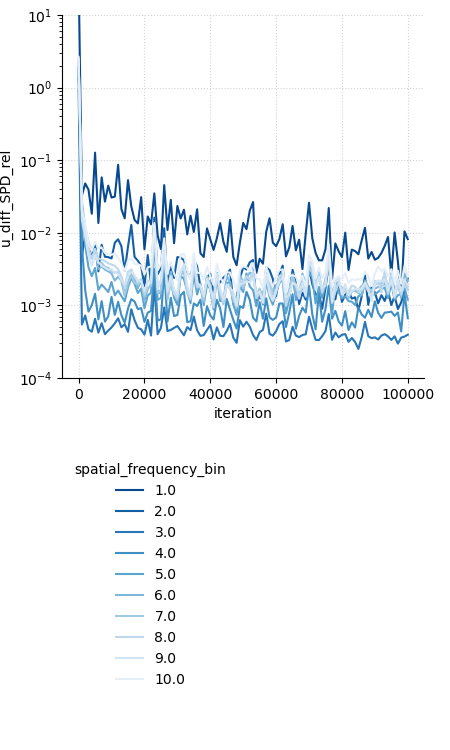

<IPython.core.display.Javascript object>


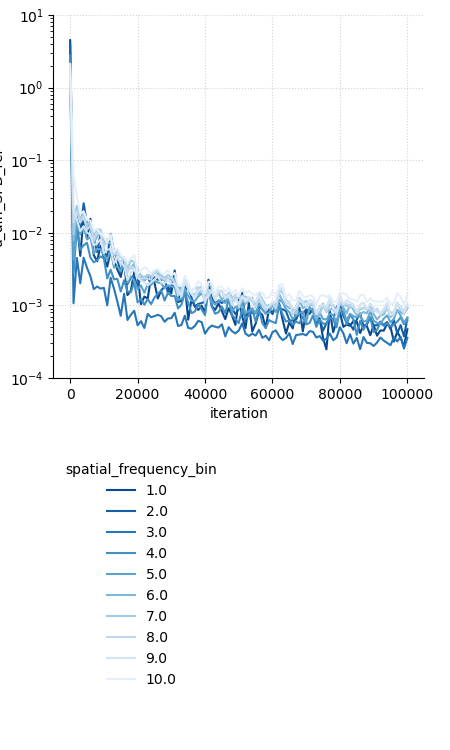

In [79]:
# investigate spectral bias
import seaborn as sns

m['u_diff_SPD_rel'] = m['u_diff_SPD'] / m['u_true_SPD']

sns.set_palette('Blues_r', 10)

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_8_512_t') & (m.spatial_frequency_bin != 'all')].copy(),
    x='iteration',
    y=['u_diff_SPD_rel'],
    hue=('spatial_frequency_bin'),
    height=7.5,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1e1)
fig.savefig('2d_experiment_power_spectrum8.png', dpi=200, bbox_inches='tight')

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_32_512_t') & (m.spatial_frequency_bin != 'all')].copy(),
    x='iteration',
    y=['u_diff_SPD_rel'],
    hue=('spatial_frequency_bin'),
    height=7.5,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1e1)
fig.savefig('2d_experiment_power_spectrum32.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


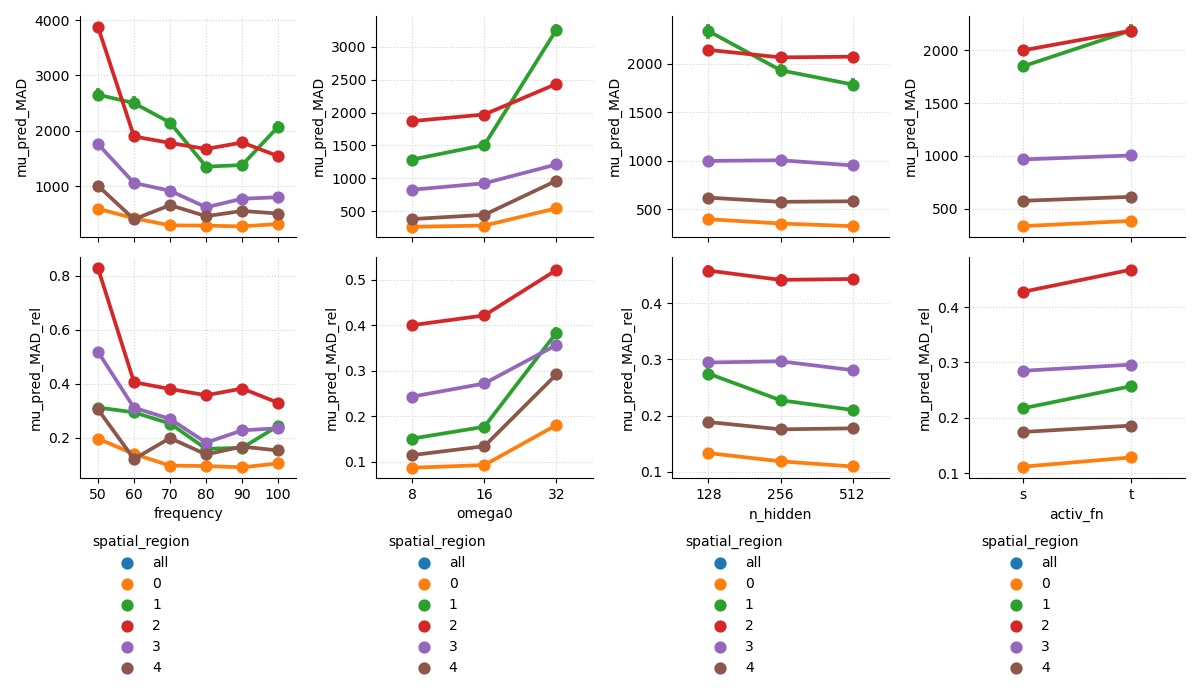

In [92]:
m['mu_pred_MAD_rel'] = m['mu_pred_MAD'] / m['mu_true_MAV']

sns.set_palette('tab10')

fig = ps.plot(
    m,
    x=param_cols,
    y=['mu_pred_MAD', 'mu_pred_MAD_rel'],
    height=3.5,
    width=3,
    hue='spatial_region',
    legend=True,
    tight=True
)

Reconstruction appears to be hardest at the lower frequencies. The performance was best using frequencies 80 or 90 and worst at frequency 50. Interestingly, the smallest targets were reconstructed best at the highest frequencies.

It's also notable here that the higher omega0 appears to HURT elasticity reconstruction performance, even through it help fit the model to the wave field.

<IPython.core.display.Javascript object>


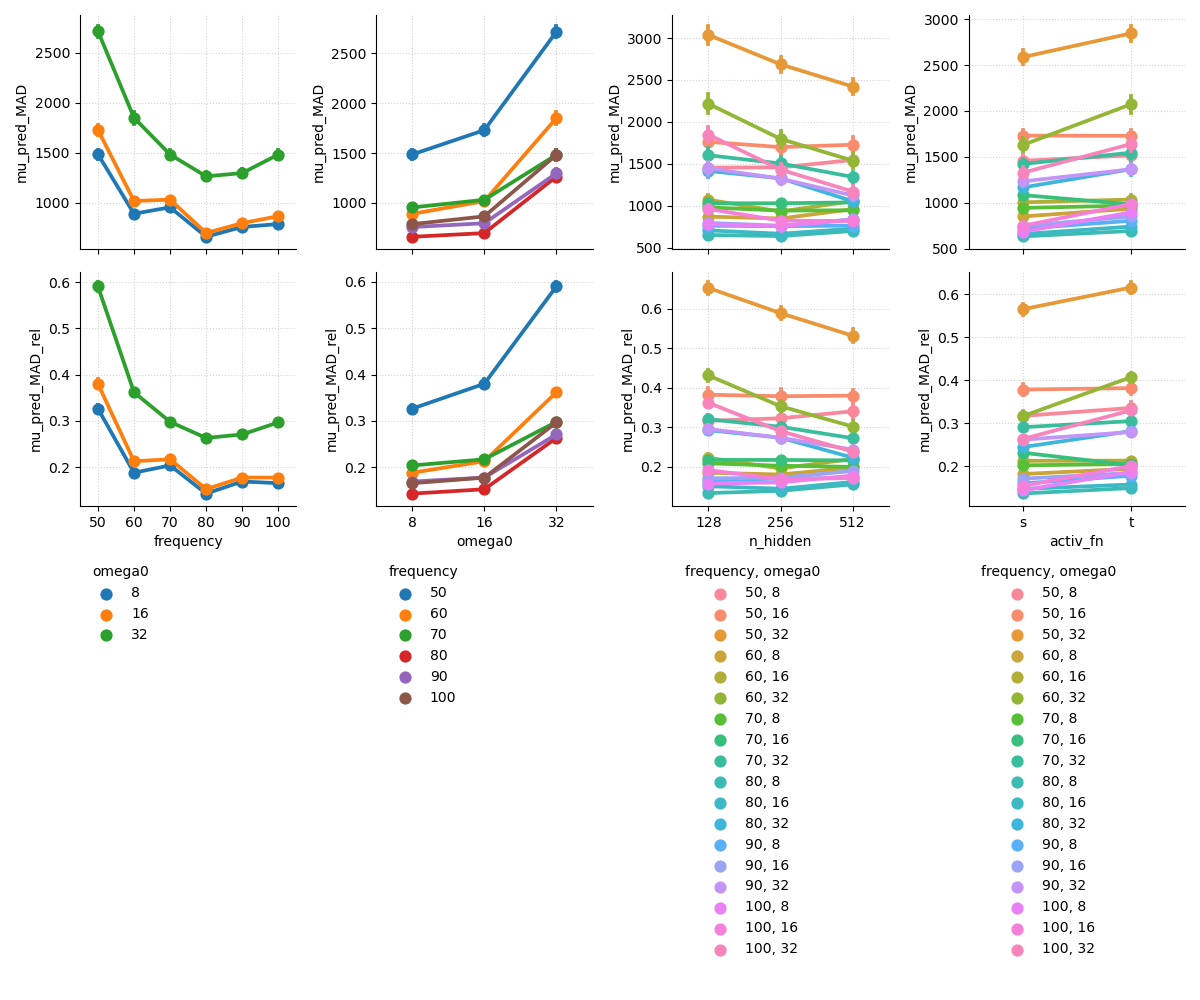

In [93]:
fig = ps.plot(
    m,
    x=param_cols,
    y=['mu_pred_MAD', 'mu_pred_MAD_rel'],
    height=5,
    width=3,
    hue=('frequency', 'omega0'),
    legend=True,
    tight=True
)
fig.savefig('2d_experiment_mu_pred_MAD_by_freq.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


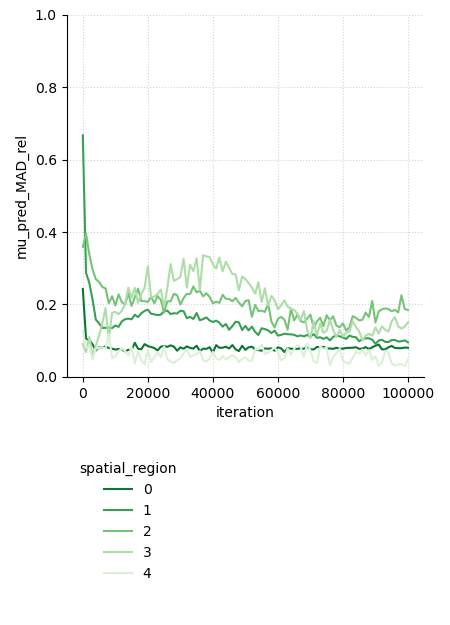

<IPython.core.display.Javascript object>


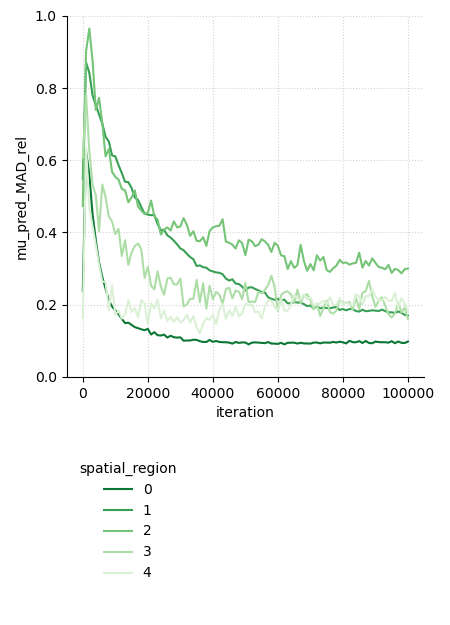

In [102]:
sns.set_palette('Greens_r', 5)

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_8_256_s') & (m.spatial_region != 'all')].copy(),
    x='iteration',
    y=['mu_pred_MAD_rel'],
    hue=('spatial_region'),
    height=6.25,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    #ax.set_yscale('log')
    ax.set_ylim(0, 1)
    pass
fig.savefig('2d_experiment_mu_pred_MAD_8.png', dpi=200, bbox_inches='tight')

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_32_256_s') & (m.spatial_region != 'all')].copy(),
    x='iteration',
    y=['mu_pred_MAD_rel'],
    hue=('spatial_region'),
    height=6.25,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    #ax.set_yscale('log')
    ax.set_ylim(0, 1)
    pass
fig.savefig('2d_experiment_mu_pred_MAD_32.png', dpi=200, bbox_inches='tight')